In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#read in csv's and merge
values_df = pd.read_csv('train_set_values.csv')
labels_df = pd.read_csv('train_set_labels.csv')
test_df = pd.read_csv('test_set_values.csv')

df= pd.merge(values_df, labels_df, on = 'id' )

df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [2]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [24]:
from imblearn.over_sampling import SMOTE
from preprocessor import DataCleaner
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingCVClassifier

In [4]:
train, test = DataCleaner(values_df, labels_df, test_df)
y = train['status_group']
X = train.drop(columns = 'status_group')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_resampled, y_resampled = smote.fit_sample(X, y)
print(y.value_counts())
print(y_resampled.value_counts())

2    32259
0    22824
1     4317
Name: status_group, dtype: int64
2    32259
1    32259
0    32259
Name: status_group, dtype: int64


In [7]:
smote_train = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_train_resampled, y_train_resampled = smote_train.fit_sample(X_train, y_train)
print(y_train.value_counts())
print(y_train_resampled.value_counts())

2    24161
0    17146
1     3243
Name: status_group, dtype: int64
2    24161
1    24161
0    24161
Name: status_group, dtype: int64


In [36]:
clf_xg = XGBClassifier( booster = 'gbtree',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .3, n_jobs = -1, subsample = 0.5, tree_method = 'auto')
scores = cross_val_score(clf_xg, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8419365544172577 +/- 0.07281686182650178


In [35]:
clf_xg = XGBClassifier( booster = 'dart',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1, subsample = 0.5)
scores = cross_val_smin_child_weight=xg, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8452225056800563 +/- 0.07251292655951536


In [37]:
clf_xg = XGBClassifier( booster = 'dart',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1, subsample = 0.5, n_estimators = 150, min_child_weight = 5)
scores = cross_val_score(clf_xg, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8473821474095692 +/- 0.07352146679239731


In [9]:
# clf_xg = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
#                       num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
#                       max_depth = 16, colsample_bytree = .4, n_jobs = -1)
# scores = cross_val_score(clf_xg, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
# print(scores.mean(), '+/-', scores.std())

0.8447505190995594 +/- 0.07219687891541138


In [38]:
clf_xg = XGBClassifier( booster = 'dart',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 16, colsample_bytree = .4, n_jobs = 4, subsample = 0.5, n_estimators = 150, min_child_weight = 5)

In [39]:
clf_xg.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.2,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=5, missing=None, n_estimators=150, n_jobs=4,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.5, verbosity=1)

In [40]:
preds_train_resampled = clf_xg.predict(X_train_resampled)
preds_train = clf_xg.predict(X_train)
preds_test = clf_xg.predict(X_test)

In [41]:
accuracy_score(y_train_resampled, preds_train_resampled)

0.9402066691500076

In [42]:
accuracy_score(y_train, preds_train)

0.9356677890011224

In [43]:
accuracy_score(y_test, preds_test)

0.9328619528619528

In [44]:
preds_main_test = clf_xg.predict(test)
submission_preds = pd.Series(preds_main_test)
submission_preds_mapped = submission_preds.map({2: 'functional', 1: 'functional needs repair', 0: 'non functional'})
submission_preds_mapped.value_counts()

functional                 8865
non functional             5346
functional needs repair     639
dtype: int64

In [45]:
submit_df = pd.concat([test_df['id'], submission_preds_mapped], axis = 1)
submit_df.rename(columns = {0: 'status_group'}, inplace = True)
submit_df.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [46]:
submit_df.to_csv('test_submit_4.csv', index = False )

In [ ]:
# prev_submission = pd.read_csv('test_submit.csv')
# prev_submission['status_group'].value_counts()

TRAIN accuracy: 0.82327721661055
TEST accuracy: 0.8048484848484848


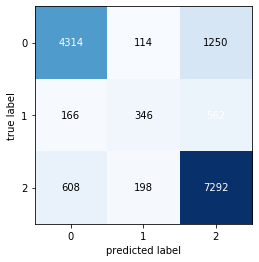

In [24]:
# Training a classifier
#try extra trees
lgm = LGBMClassifier(random_state = 42, max_depth=8, n_estimators=150, boosting_type='gbdt')
pipe2 = make_pipeline(lgm)
pipe2.fit(X_train_resampled, y_train_resampled)
# make predictions on training set
y_guess = pipe2.predict(X_train)
# make predictions on hold-out set
y_score = pipe2.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()


TRAIN accuracy: 0.820381593714927
TEST accuracy: 0.8201346801346802


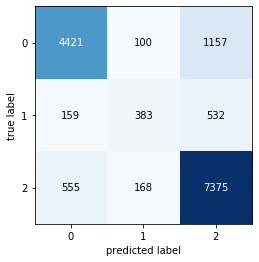

In [25]:
# Training a classifier
#try extra trees
lgm = LGBMClassifier(random_state = 42, max_depth=8, n_estimators=150, boosting_type='gbdt')
pipe2 = make_pipeline(lgm)
pipe2.fit(X_resampled, y_resampled)
# make predictions on training set
y_guess = pipe2.predict(X_train)
# make predictions on hold-out set
y_score = pipe2.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [26]:
pipe2.fit(X_resampled, y_resampled)

Pipeline(memory=None,
         steps=[('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=8,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=150, n_jobs=-1,
                                num_leaves=31, objective=None, random_state=42,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0))],
         verbose=False)

In [27]:
preds_train_resampled = pipe2.predict(X_train_resampled)
preds_train = pipe2.predict(X_train)
preds_test = pipe2.predict(X_test)

In [28]:
accuracy_score(y_train_resampled, preds_train_resampled)

0.8750687358709599

In [29]:
accuracy_score(y_train, preds_train)

0.820381593714927

In [30]:
accuracy_score(y_test, preds_test)

0.8201346801346802

In [31]:
preds_main_test = pipe2.predict(test)

In [32]:
submission_preds = pd.Series(preds_main_test)

In [33]:
test_df['id']

0        50785
1        51630
2        17168
3        45559
4        49871
         ...  
14845    39307
14846    18990
14847    28749
14848    33492
14849    68707
Name: id, Length: 14850, dtype: int64

In [34]:
submission_preds_mapped = submission_preds.map({2: 'functional', 1: 'functional needs repair', 0: 'non functional'})

In [35]:
submission_preds_mapped.value_counts()

functional                 9132
non functional             5139
functional needs repair     579
dtype: int64

In [36]:
submit_df = pd.concat([test_df['id'], submission_preds_mapped], axis = 1)

In [37]:
submit_df.rename(columns = {0: 'status_group'}, inplace = True)

In [38]:
submit_df

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


TRAIN accuracy: 0.9710886644219977
TEST accuracy: 0.9693602693602693


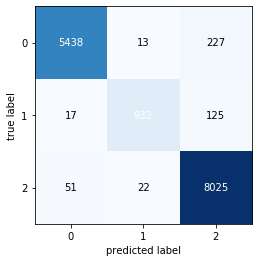

In [39]:
# Training a classifier
#try extra trees
pipe2 = make_pipeline(clf_xg)
pipe2.fit(X_resampled, y_resampled)
# make predictions on training set
y_guess = pipe2.predict(X_train)
# make predictions on hold-out set
y_score = pipe2.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

TRAIN accuracy: 0.8104826038159372
TEST accuracy: 0.8101683501683502


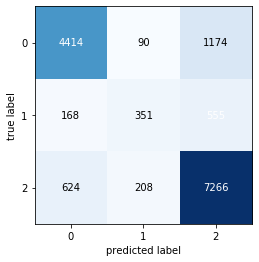

In [40]:
sclf = StackingCVClassifier(classifiers=[lgm],
                            use_probas=True, 
                            meta_classifier=clf_xg,
                            random_state=42)
sclf.fit(X_resampled, y_resampled)
# make predictions on training set
y_guess = sclf.predict(X_train)
# make predictions on hold-out set
y_score = sclf.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [41]:
y_resampled_binary = y_resampled.replace(2,1)

In [42]:
y_resampled.value_counts()

2    32259
1    32259
0    22824
Name: status_group, dtype: int64

In [43]:
y_resampled_binary

0        1
1        1
2        1
3        0
4        1
        ..
87337    1
87338    1
87339    1
87340    1
87341    1
Name: status_group, Length: 87342, dtype: int64

In [44]:
y_binary = y.replace(2,1)

In [45]:
y_binary.value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

In [46]:
smote = SMOTE(n_jobs = -1)
X_resampled, y_resampled = smote.fit_sample(X, y_binary)
print(y.value_counts())
print(y_resampled.value_counts())

2    32259
0    22824
1     4317
Name: status_group, dtype: int64
1    36576
0    36576
Name: status_group, dtype: int64


In [47]:
clf_xg = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 2, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)

TRAIN accuracy: 0.43914702581369247
TEST accuracy: 0.43643097643097645


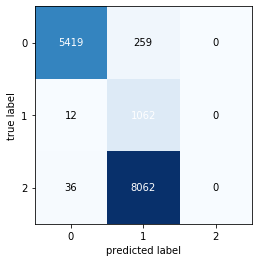

In [48]:
# Training a classifier
#try extra trees
pipe2 = make_pipeline(clf_xg)
pipe2.fit(X_resampled, y_resampled)
# make predictions on training set
y_guess = pipe2.predict(X_train)
# make predictions on hold-out set
y_score = pipe2.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

TRAIN accuracy: 0.3577328843995511
TEST accuracy: 0.3552188552188552


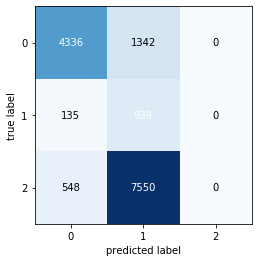

In [49]:
sclf = StackingCVClassifier(classifiers=[lgm],
                            use_probas=True, 
                            meta_classifier=clf_xg,
                            random_state=42)
sclf.fit(X_resampled, y_resampled)
# make predictions on training set
y_guess = sclf.predict(X_train)
# make predictions on hold-out set
y_score = sclf.predict(X_test)
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [50]:
# submit_df.to_csv('test_submit.csv', index = False )

In [51]:
# test_used_cols = [c for c in test.columns.tolist() if c not in ['id']]
# X_test = test[test_used_cols]
# test_predict = clf_xg.predict(X_test)
# df_test['status_group'] = pd.Series(test_predict, index=df_test.id)
# df_test['status_group'] = test_predict
# df_test['status_group'] = test['status_group'].replace(0 ,'non functional') #0 is not functional
# df_test['status_group'] = test['status_group'].replace(1, 'functional needs repair') #1 is functional
# df_test['status_group'] = test['status_group'].replace(2, 'functional') #1 is functional
# df_submit = df_test[['id', 'status_group']]